# This script is for the exploration of SEP740 G22 final project.
# Authors: Yifei Zhou, Iliyan Moosani, Jian Guan.

In [1]:
import os
import statistics
import math
from pprint import pprint

import random
from typing import List, NamedTuple

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#################
# Set the random seed for reproducible results.
#################
RANDOM_SEED = random.randint(0, 1000)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Ensure deterministic behavior in Pytorch.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#################
# Set the device to GPU if available.
#################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

/tmp/ipykernel_106181/455828705.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


Device: cpu


From file dataframe shape: (32561, 15)
Dataframe desc:
                age        fnlwgt  education.num  capital.gain  capital.loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

Datafra

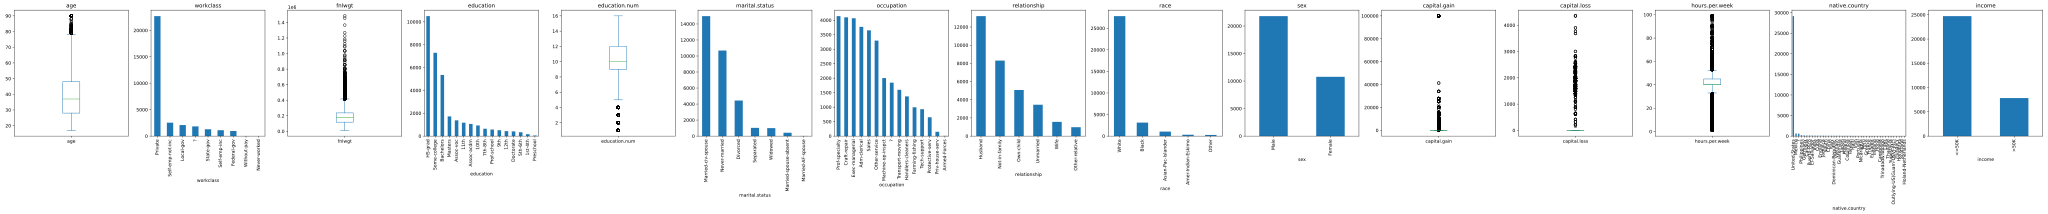

In [2]:
#################
# Dataset loading
#################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session.


kaggle_input_dir = '/kaggle/input'
local_input_dir = './input'
input_dir = kaggle_input_dir if os.path.exists(kaggle_input_dir) else local_input_dir
dataset_path = os.path.join(input_dir, 'adult-census-income/adult.csv')

df = pd.read_csv(dataset_path)

def show_dataframe(df):
    print(f'Dataframe desc:\n{df.describe()}')
    print(f'\nDataframe info:\n{df.info}')

    num_cols = df.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(80, 5)) 
    col_idx = 0
    for col, dtype in df.dtypes.items():
        axes[col_idx].set_title(col)
        if dtype in ('int64', 'float64', 'int32', 'float32'):
            df[col].plot(kind='box', ax=axes[col_idx])
        elif dtype in ('object', 'category', 'int8'):
            df[col].value_counts().plot(kind='bar', ax=axes[col_idx])
        else:
            pass
        col_idx += 1    
    plt.subplots_adjust(wspace=0.2)        
    plt.show()

print(f"From file dataframe shape: {df.shape}")
show_dataframe(df)


In [3]:
# This processor will normalize all the columns in the dataset, and then split the dataset into train and test datasets.
# The normalization is done by subtracting the mean and then dividing by the standard deviation.
# The train and test datasets are split by the test_size parameter.
# The train and test datasets are then converted to PyTorch tensors.
def all_normalization_processor(df: pd.DataFrame, test_size: float, random_state: int = RANDOM_SEED):
    new_df = df.copy(deep=True)
    
    # Note that the categorical_columns and continues_columns are processed separately and then merged.
    # It is worth noting that:
    # 1. For categorical_columns, we used OneHotEncoder for encoding. This encoding will expand new columns, so we need to record the names of these columns.
    # 2. For continues_columns, we used standardization, specifically z-score standardization, which means for each column, we subtract the mean and then divide by the standard deviation.
    # 3. Finally, we merge these two parts to get feature_train_tensor and feature_test_tensor. Here we use torch.tensor to convert pandas DataFrame to Tensor, and then use torch.cat to merge the two Tensors.
    #    If we use df to merge, there will be problems because the index of df is not continuous, while the index of tensor is continuous.
    categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
    continues_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
    label_column = 'income'
    assert len(categorical_columns) + len(continues_columns) + 1 == new_df.shape[1]


    for col in categorical_columns:
        new_df[col] = new_df[col].astype('category')
        new_df[col] = new_df[col].cat.codes
    new_df[label_column] = new_df[label_column].astype('category')
    new_df[label_column] = new_df[label_column].cat.codes

    feature = new_df[categorical_columns + continues_columns]
    label = new_df[label_column]

    #print(f"\nFeature after set category codes:")
    #show_dataframe(feature)

    # Split to train and test datasets.
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=test_size, random_state=random_state, stratify=label)
    print(f'\nBefore one hot, feature train shape: {feature_train.shape}')
    print(f'\nBefore one hot, feature test shape: {feature_test.shape}')

    # One-hot encode the categorical columns.
    encoder = OneHotEncoder(sparse_output=False)
    feature_onehot_train = encoder.fit_transform(feature_train[categorical_columns])
    feature_onehot_test = encoder.transform(feature_test[categorical_columns])
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    feature_onehot_train = pd.DataFrame(feature_onehot_train, columns=encoded_columns)
    feature_onehot_test = pd.DataFrame(feature_onehot_test, columns=encoded_columns)


    print(f"\nCategorical features after onehot encoding:")
    print(f'\nShape: {feature_onehot_train.shape}')
    #show_dataframe(feature_onehot_train)

    # Standard normalize the continues columns.
    # TODO: max min normalization.
    feature_norm_train = (feature_train[continues_columns] - feature_train[continues_columns].mean()) / feature_train[continues_columns].std()
    feature_norm_test = (feature_test[continues_columns] - feature_test[continues_columns].mean()) / feature_test[continues_columns].std()
    print(f"\nContinues features after normalization:")
    print(f'\nShape: {feature_norm_train.shape}')
    #show_dataframe(feature_norm_train)


    feature_onehot_train_tensor = torch.tensor(feature_onehot_train.values, dtype=torch.float32).to(device)
    print(f'\nfeature_onehot_train_tensor shape: {feature_onehot_train_tensor.shape}')
    feature_norm_train_tensor = torch.tensor(feature_norm_train.values, dtype=torch.float32).to(device)
    train_feature_tensor = torch.cat([feature_onehot_train_tensor, feature_norm_train_tensor], dim=1)
    train_label_tensor = torch.tensor(label_train.values, dtype=torch.float32).to(device)

    feature_onehot_test_tensor = torch.tensor(feature_onehot_test.values, dtype=torch.float32).to(device)
    feature_norm_test_tensor = torch.tensor(feature_norm_test.values, dtype=torch.float32).to(device)
    test_feature_tensor = torch.cat([feature_onehot_test_tensor, feature_norm_test_tensor], dim=1)
    test_label_tensor = torch.tensor(label_test.values, dtype=torch.float32).to(device)

    return train_feature_tensor, train_label_tensor, test_feature_tensor, test_label_tensor

# OneHotEncoding for all categorial features + normalization on continues columns


In [4]:

# All columns with no normalization.

def all_processor(df: pd.DataFrame, test_size: float, random_state: int = RANDOM_SEED):
    new_df = df.copy(deep=True)
    
    categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
    continues_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
    label_column = 'income'
    assert len(categorical_columns) + len(continues_columns) + 1 == new_df.shape[1]


    for col in categorical_columns:
        new_df[col] = new_df[col].astype('category')
        new_df[col] = new_df[col].cat.codes
    new_df[label_column] = new_df[label_column].astype('category')
    new_df[label_column] = new_df[label_column].cat.codes

    feature = new_df[categorical_columns + continues_columns]
    label = new_df[label_column]

    #print(f"\nFeature after set category codes:")
    #show_dataframe(feature)

    # Split to train and test datasets.
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=test_size, random_state=random_state, stratify=label)
    print(f'\nBefore one hot, feature train shape: {feature_train.shape}')
    print(f'\nBefore one hot, feature test shape: {feature_test.shape}')

    # One-hot encode the categorical columns.
    encoder = OneHotEncoder(sparse_output=False)
    feature_onehot_train = encoder.fit_transform(feature_train[categorical_columns])
    feature_onehot_test = encoder.transform(feature_test[categorical_columns])
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    feature_onehot_train = pd.DataFrame(feature_onehot_train, columns=encoded_columns)
    feature_onehot_test = pd.DataFrame(feature_onehot_test, columns=encoded_columns)


    print(f"\nCategorical features after onehot encoding:")
    print(f'\nShape: {feature_onehot_train.shape}')
    #show_dataframe(feature_onehot_train)

    feature_onehot_train_tensor = torch.tensor(feature_onehot_train.values, dtype=torch.float32).to(device)
    print(f'\nfeature_onehot_train_tensor shape: {feature_onehot_train_tensor.shape}')
    feature_norm_train_tensor = torch.tensor(feature_train.values, dtype=torch.float32).to(device)
    train_feature_tensor = torch.cat([feature_onehot_train_tensor, feature_norm_train_tensor], dim=1)
    train_label_tensor = torch.tensor(label_train.values, dtype=torch.float32).to(device)

    feature_onehot_test_tensor = torch.tensor(feature_onehot_test.values, dtype=torch.float32).to(device)
    feature_norm_test_tensor = torch.tensor(feature_test.values, dtype=torch.float32).to(device)
    test_feature_tensor = torch.cat([feature_onehot_test_tensor, feature_norm_test_tensor], dim=1)
    test_label_tensor = torch.tensor(label_test.values, dtype=torch.float32).to(device)

    return train_feature_tensor, train_label_tensor, test_feature_tensor, test_label_tensor

# OneHotEncoding for all categorial features + no_normalization on continues columns

In [5]:
# Dataset processor from Yifei and modified by me.

def preprocess_adult_dataset(df, process=['1', '2', '3a', '3b', '3c']):
    """
    Preprocess the Adult dataset with specified transformations
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with Adult dataset
    
    Returns:
    --------
    pandas.DataFrame
        Preprocessed dataframe
    """
    # Step 1: Drop insignificant columns
    if '1' in process:
        columns_to_drop = ['education', 'fnlwgt', 'race', 'native.country']
        df = df.drop(columns=columns_to_drop)
    
    # Step 2: Handle Missing Values
    # Create 'Unknown' category for 'occupation' and 'workclass'
    if '2' in process:
        df = df.replace('?', np.nan)
        df['occupation'] = df['occupation'].fillna('Unknown')
        df['workclass'] = df['workclass'].fillna('Unknown')
        
        # Drop rows with any remaining missing values
        df = df.dropna()
    
    # Step 3a: Bin Relationship Feature
    if '3a' in process:
        relationship_mapping = {
            'Husband': 'Spouse',
            'Wife': 'Spouse',
            'Own-child': 'Non-spouse Dependents',
            'Other-relative': 'Non-spouse Dependents',
            'Not-in-family': 'Independent',
            'Unmarried': 'Independent'
        }
        df['relationship_binned'] = df['relationship'].map(relationship_mapping)
        # Remove original columns that have been binned
        df = df.drop(columns=['relationship'])
    
    # Step 3b: Bin Marital Status
    if '3b' in process:
        marital_status_mapping = {
            'Married-civ-spouse': 'Married',
            'Married-AF-spouse': 'Married',
            'Divorced': 'Previously Married',
            'Widowed': 'Previously Married',
            'Separated': 'Previously Married',
            'Never-married': 'Never Married'
        }
        df['marital_status_binned'] = df['marital.status'].map(marital_status_mapping)
        # Remove original columns that have been binned
        df = df.drop(columns=['marital.status'])
    
    # Step 3c: Bin Education Years
    if '3c' in process:
        def bin_education_years(years):
            if years <= 9:
                return 'Low Education'
            elif 9 < years <= 10:
                return 'Moderate Education'
            elif 10 < years <= 13:
                return 'High Education'
            else:
                return 'Higher Education'
        
        df['education_years_binned'] = df['education.num'].apply(bin_education_years)
        # Remove original columns that have been binned
        df = df.drop(columns=['education.num'])
    
    return df


def drop_column_processor(df: pd.DataFrame, test_size: float, random_state: int = RANDOM_SEED, process=['1', '2', '3a', '3b', '3c']):
    # Preprocess from Yifei.
    new_df = df.copy(deep=True)
    
    new_df = preprocess_adult_dataset(new_df, process)

    categorical_columns = ['education', 'race', 'native.country', 'workclass', 'occupation', 'sex', 'relationship', 'relationship_binned', 'marital.status', 'marital_status_binned', 'education_years_binned']
    continues_columns = ['age', 'education.num', 'fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']
    if '1' in process:
        #['education', 'fnlwgt', 'race', 'native.country']
        categorical_columns = [ele for ele in categorical_columns if ele not in ['education', 'race', 'native.country']]
        continues_columns.remove('fnlwgt')
    else:
        pass
    if '3a' in process:
        categorical_columns.remove('relationship')
    else:
        categorical_columns.remove('relationship_binned')
    if '3b' in process:
        categorical_columns.remove('marital.status')
    else:
        categorical_columns.remove('marital_status_binned')
    if '3c' in process:
        continues_columns.remove('education.num')
    else:
        categorical_columns.remove('education_years_binned')
    
    label_column = 'income'
    assert len(categorical_columns) + len(continues_columns) + 1 == new_df.shape[1]

    for col in categorical_columns:
        new_df[col] = new_df[col].astype('category')
        new_df[col] = new_df[col].cat.codes
    new_df[label_column] = new_df[label_column].astype('category')
    new_df[label_column] = new_df[label_column].cat.codes

    feature = new_df[categorical_columns + continues_columns]
    label = new_df[label_column]

    # Split to train and test datasets.
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=test_size, random_state=random_state, stratify=label)
    print(f'\nBefore one hot, feature train shape: {feature_train.shape}')
    print(f'\nBefore one hot, feature test shape: {feature_test.shape}')

    # One-hot encode the categorical columns.
    encoder = OneHotEncoder(sparse_output=False)
    feature_onehot_train = encoder.fit_transform(feature_train[categorical_columns])
    feature_onehot_test = encoder.transform(feature_test[categorical_columns])
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    feature_onehot_train = pd.DataFrame(feature_onehot_train, columns=encoded_columns)
    feature_onehot_test = pd.DataFrame(feature_onehot_test, columns=encoded_columns)


    print(f"\nCategorical features after onehot encoding:")
    print(f'\nShape: {feature_onehot_train.shape}')
    #show_dataframe(feature_onehot_train)

    # Standard normalize the continues columns.
    # TODO: max min normalization.
    feature_norm_train = (feature_train[continues_columns] - feature_train[continues_columns].mean()) / feature_train[continues_columns].std()
    feature_norm_test = (feature_test[continues_columns] - feature_test[continues_columns].mean()) / feature_test[continues_columns].std()
    print(f"\nContinues features after normalization:")
    print(f'\nShape: {feature_norm_train.shape}')
    #show_dataframe(feature_norm_train)


    feature_onehot_train_tensor = torch.tensor(feature_onehot_train.values, dtype=torch.float32).to(device)
    print(f'\nfeature_onehot_train_tensor shape: {feature_onehot_train_tensor.shape}')
    feature_norm_train_tensor = torch.tensor(feature_norm_train.values, dtype=torch.float32).to(device)
    train_feature_tensor = torch.cat([feature_onehot_train_tensor, feature_norm_train_tensor], dim=1)
    train_label_tensor = torch.tensor(label_train.values, dtype=torch.float32).to(device)

    feature_onehot_test_tensor = torch.tensor(feature_onehot_test.values, dtype=torch.float32).to(device)
    feature_norm_test_tensor = torch.tensor(feature_norm_test.values, dtype=torch.float32).to(device)
    test_feature_tensor = torch.cat([feature_onehot_test_tensor, feature_norm_test_tensor], dim=1)
    test_label_tensor = torch.tensor(label_test.values, dtype=torch.float32).to(device)

    return train_feature_tensor, train_label_tensor, test_feature_tensor, test_label_tensor
    
# pre-processing + OneHotEncoding + data normalization

In [6]:
def all_ord_normalization_processor(df: pd.DataFrame, test_size: float, random_state: int = RANDOM_SEED):  
    # Note that the categorical_columns and continues_columns are processed separately and then merged.
    # This version uses pure Ordinal Encoding instead of One-Hot Encoding
    categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
    continues_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
    label_column = 'income'
    assert len(categorical_columns) + len(continues_columns) + 1 == df.shape[1]

    # Use OrdinalEncoder for categorical columns
    from sklearn.preprocessing import OrdinalEncoder

    # Create an OrdinalEncoder
    ord_encoder = OrdinalEncoder()

    # Prepare a copy of the dataframe to avoid modifying the original
    df_encoded = df.copy(deep=True)

    # Encode categorical columns
    df_encoded[categorical_columns] = ord_encoder.fit_transform(df[categorical_columns])
    
    # Encode label column
    df_encoded[label_column] = df_encoded[label_column].astype('category').cat.codes

    # Separate features and label
    feature = df_encoded[categorical_columns + continues_columns]
    label = df_encoded[label_column]

    # Split to train and test datasets
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=test_size, random_state=random_state, stratify=label)
    print(f'\nFeature train shape: {feature_train.shape}')
    print(f'\nFeature test shape: {feature_test.shape}')

    # Standard normalize the continues columns
    feature_norm_train = (feature_train[continues_columns] - feature_train[continues_columns].mean()) / feature_train[continues_columns].std()
    feature_norm_test = (feature_test[continues_columns] - feature_test[continues_columns].mean()) / feature_test[continues_columns].std()
    print(f"\nContinues features after normalization:")
    print(f'\nShape: {feature_norm_train.shape}')

    # Prepare ordinal-encoded categorical columns
    feature_ord_train = feature_train[categorical_columns]
    feature_ord_test = feature_test[categorical_columns]

    # Convert to tensors
    feature_ord_train_tensor = torch.tensor(feature_ord_train.values, dtype=torch.float32).to(device)
    feature_norm_train_tensor = torch.tensor(feature_norm_train.values, dtype=torch.float32).to(device)
    train_feature_tensor = torch.cat([feature_ord_train_tensor, feature_norm_train_tensor], dim=1)
    train_label_tensor = torch.tensor(label_train.values, dtype=torch.float32).to(device)

    feature_ord_test_tensor = torch.tensor(feature_ord_test.values, dtype=torch.float32).to(device)
    feature_norm_test_tensor = torch.tensor(feature_norm_test.values, dtype=torch.float32).to(device)
    test_feature_tensor = torch.cat([feature_ord_test_tensor, feature_norm_test_tensor], dim=1)
    test_label_tensor = torch.tensor(label_test.values, dtype=torch.float32).to(device)

    return train_feature_tensor, train_label_tensor, test_feature_tensor, test_label_tensor

# OrdinalEncoding for all categorical features + normalization on continues columns

In [7]:
  # Model Factory, create model by name.
class ModelFactory():
    class ANNModel(nn.Module):
        def __init__(self, input_size, hidden_layers, dropout, output_size, acti):
            super(ModelFactory.ANNModel, self).__init__()
            assert len(hidden_layers) > 0
            self.input = nn.Linear(input_size, hidden_layers[0])
            self.hidden = nn.ModuleList()
            self.dropout = nn.Dropout(dropout) if dropout else None
            for i in range(1, len(hidden_layers)):
                self.hidden.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.output = nn.Linear(hidden_layers[-1], output_size)
            self.acti = getattr(F, acti) if acti is not None else None
        
        def forward(self, x):
            x = self.input(x)
            x = self.acti(x) if self.acti is not None else x
            x = self.dropout(x) if self.dropout is not None else x
            for layer in self.hidden:
                x = layer(x)
                x = self.acti(x) if self.acti is not None else x
                x = self.dropout(x) if self.dropout is not None else x
            x = self.output(x)
            return x
    @classmethod
    def create_model(self, model_name, **kwargs):
        model_class = getattr(ModelFactory, model_name, None)
        if model_class is None:
          raise ValueError(f"Model {model_name} is not supported.")
        return model_class(**kwargs)


# Optimizer Factory, create optimizer by name.
class OptimizerFactory:
    @staticmethod
    def create_optimizer(optimizer_name, model_parameters, **kwargs):
        optimizer_class = getattr(torch.optim, optimizer_name, None)
        if optimizer_class is None:
            raise ValueError(f"Optimizer {optimizer_name} is not supported.")
        return optimizer_class(model_parameters, **kwargs)

# Loss Function Factory, create loss function by name.
class LossFunctionFactory:
    @staticmethod
    def create_loss_function(name, **kwargs):
        loss_function_class = getattr(nn, name, None)
        if loss_function_class is None:
            raise ValueError(f"Loss function {name} is not supported.")
        return loss_function_class(**kwargs)

def calculate_metrics(y_true, y_pred):
    y_pred = torch.sigmoid(y_pred).cpu().numpy()
    y_pred = np.round(y_pred)
    y_true = y_true.cpu().numpy()
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_pred, zero_division=0), \
        f1_score(y_true, y_pred, zero_division=0), confusion_matrix(y_true, y_pred)

# Test the calculate_metrics function
y_true_test = torch.tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32)
y_pred_test = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=torch.float32)

metrics = calculate_metrics(y_true_test, y_pred_test)
print("Accuracy:", metrics[0])
print("Precision:", metrics[1])
print("Recall:", metrics[2])
print("F1 Score:", metrics[3])
print("Confusion Matrix:\n", metrics[4])

Accuracy: 0.7
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[7 0]
 [3 0]]


In [8]:

class ModelTrainer():
    def __init__(self, model, optimizer, loss_function, dataloader_train, val_features, val_labels, epochs):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.dataloader_train = dataloader_train
        self.val_features = val_features
        self.val_labels = val_labels
        self.epochs = epochs

    def train(self, plot=False):
        self.model.train()  # Set the model to training mode.
        epoch_train_avg_losses = []
        epoch_val_losses = []
        epoch_val_accuracies = []
        epoch_val_precisions = []
        epoch_val_recalls = []
        epoch_val_f1_scores = []
        epoch_val_confusion_matrices = []
        for epoch in range(self.epochs):
            iter_losses = []
            for i, (feature, label) in enumerate(self.dataloader_train):
                # Forward pass and compute the loss.
                output = self.model(feature)
                output = output.squeeze()
                loss = self.loss_function(output, label)

                # Backward pass and optimize the model.
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Log the loss.
                # if i % 500 == 0:
                #     print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")
                iter_losses.append(loss.item())
            epoch_train_avg_losses.append(statistics.mean(iter_losses))
            # Validation.
            self.model.eval()  # Set the model to evaluation mode.
            with torch.no_grad():  # Disable gradient calculation for validation.
                # Forward pass and compute the loss.
                output = self.model(self.val_features)
                output = output.squeeze()
                loss = self.loss_function(output, self.val_labels)
                accuracy, precision_score, recall_score, f1_score, confusion_matrix = calculate_metrics(self.val_labels, output)
                epoch_val_losses.append(loss.item())
                epoch_val_accuracies.append(accuracy)
                epoch_val_precisions.append(precision_score)
                epoch_val_recalls.append(recall_score)
                epoch_val_f1_scores.append(f1_score)
                epoch_val_confusion_matrices.append(confusion_matrix)

            self.model.train()  # Set the model back to training mode.

        # Plotting validation metrics over epochs.
        if plot:
            fig, axs = plt.subplots(1, 3,figsize=(20, 5))
    
            # Group 1: Loss
            axs[0].plot(range(self.epochs), epoch_train_avg_losses, label='Train Avg Loss')
            axs[0].plot(range(self.epochs), epoch_val_losses, label='Val Loss')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].set_title('Training/Validation Loss')
            axs[0].legend()
    
            # Group 2: Accuracy, Precision, and Recall
            axs[1].plot(range(self.epochs), epoch_val_accuracies, label='Val Accuracy')
            axs[1].plot(range(self.epochs), epoch_val_precisions, label='Val Precision')
            axs[1].plot(range(self.epochs), epoch_val_recalls, label='Val Recall')
            axs[1].plot(range(self.epochs), epoch_val_f1_scores, label='Val F1 Score')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Metrics')
            axs[1].set_title('Accuracy, Precision, Recall, and F1 Score')
            axs[1].legend()
    
            # Group 3: Confusion Matrix
            sns.heatmap(epoch_val_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', ax=axs[2])
            axs[2].set_xlabel('Predicted')
            axs[2].set_ylabel('True')
            axs[2].set_title('Confusion Matrix')
    
            plt.tight_layout()
            plt.show()
        return epoch_val_accuracies[-1], epoch_val_precisions[-1], epoch_val_recalls[-1], epoch_val_f1_scores[-1], epoch_val_confusion_matrices[-1]

In [9]:
dataset_params = {
    'all,no-norm,bs64': {'processor': all_processor, 'processor_param': {'df': df, 'test_size': 0.2}, 'bs': 64},
    'all,norm,bs64': {'processor': all_normalization_processor, 'processor_param': {'df': df, 'test_size': 0.2}, 'bs': 64},
    'drop,123a3b3c,norm,bs64': {'processor': drop_column_processor, 'processor_param': {'df': df, 'test_size': 0.2, 'process': ['1', '2', '3a', '3b', '3c']}, 'bs': 64},
    'drop,1,norm,bs64': {'processor': drop_column_processor, 'processor_param': {'df': df, 'test_size': 0.2, 'process': ['1']}, 'bs': 64},
    'drop,2,norm,bs64': {'processor': drop_column_processor, 'processor_param': {'df': df, 'test_size': 0.2, 'process': ['2']}, 'bs': 64},
    'drop,3a,norm,bs64': {'processor': drop_column_processor, 'processor_param': {'df': df, 'test_size': 0.2, 'process': ['3a']}, 'bs': 64},
    'drop,3b,norm,bs64': {'processor': drop_column_processor, 'processor_param': {'df': df, 'test_size': 0.2, 'process': ['3b']}, 'bs': 64},
    'drop,3c,norm,bs64': {'processor': drop_column_processor, 'processor_param': {'df': df, 'test_size': 0.2, 'process': ['3c']}, 'bs': 64},
    'all,ord,norm,bs64': {'processor': all_ord_normalization_processor, 'processor_param': {'df': df, 'test_size': 0.2}, 'bs': 64},
}
model_params = {
    'ANN,4*4': {    # Different model structures. 
        'model_name': 'ANNModel',
        'hidden_layers': [4]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,8*4': {    # Different model structures. 
        'model_name': 'ANNModel',
        'hidden_layers': [8]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,16*2': {
        'model_name': 'ANNModel',
        'hidden_layers': [16,16],
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,16*4': {
        'model_name': 'ANNModel',
        'hidden_layers': [16]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,16*8': {
        'model_name': 'ANNModel',
        'hidden_layers': [16]*8,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,32': {
        'model_name': 'ANNModel',
        'hidden_layers': [32],
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,32*2': {
        'model_name': 'ANNModel',
        'hidden_layers': [32]*2,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,32*4': {
        'model_name': 'ANNModel',
        'hidden_layers': [32]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,32*4,acti:relu': {
        'model_name': 'ANNModel',
        'hidden_layers': [32]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,32*4,acti:relu,drop0.5': {
        'model_name': 'ANNModel',
        'hidden_layers': [32]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,32*8': {
        'model_name': 'ANNModel',
        'hidden_layers': [32]*8,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*2': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*2,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:relu': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:relu,drop0': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.0,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:relu,drop0.1': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.1,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:relu,drop0.3': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.3,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:relu,drop0.5': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:relu,drop0.7': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.7,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*4,acti:nan': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': None,
    },
    'ANN,64*4,acti:sigmoid': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'sigmoid',
    },
    'ANN,64*4,acti:tanh': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'tanh',
    },
    'ANN,64*4,acti:leaky relu': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'leaky_relu',
    },
    'ANN,64*5': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*5,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,64*8': {
        'model_name': 'ANNModel',
        'hidden_layers': [64]*8,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,128*4': {
        'model_name': 'ANNModel',
        'hidden_layers': [128]*4,
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,4,16,32,64,128': {
        'model_name': 'ANNModel',
        'hidden_layers': [4, 16, 32, 64, 128],
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,128,64,32,16,4': {
        'model_name': 'ANNModel',
        'hidden_layers': [128, 64, 32, 16, 4],
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,4,32,128,32,4': {
        'model_name': 'ANNModel',
        'hidden_layers': [4, 32, 128, 32, 4],
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    },
    'ANN,128,32,4,32,128': {
        'model_name': 'ANNModel',
        'hidden_layers': [128, 32, 4, 32, 128],
        'dropout': 0.5,
        'output_size': 1,
        'acti': 'relu',
    }
}
epochs = 30
optimizer_params = {
    'SGD,lr1e-3': {
        'optimizer_name': 'SGD',
        'lr': 1e-3,
    },
    'SGD,lr1e-2': {
        'optimizer_name': 'SGD',
        'lr': 1e-2,
    },
    'SGD,lr1e-1': {
        'optimizer_name': 'SGD',
        'lr': 1e-1,
    },
    'Adam,lr1e-3': {
        'optimizer_name': 'Adam',
        'lr': 1e-3,
    },
    'Adam,lr1e-2': {
        'optimizer_name': 'Adam',
        'lr': 1e-2,
    },
    'Adam,lr1e-1': {
        'optimizer_name': 'Adam',
        'lr': 1e-1,
    },
    'Adam,lr5e-4': {
        'optimizer_name': 'Adam',
        'lr': 5e-4,
    },
}

class Config(NamedTuple):
    dataset: str
    model: str
    optimizer: str


epochs = 30

In [10]:
## Run the experiments.

def run_experiment(configs, plot=False):
    results = {
        'Configs': [],
        'Eval Accuracy': [],
        'Eval Precision': [],
        'Eval Recall': [],
        'Eval F1 Score': [],
    }
    
    for config in configs:
        print(f"Config: {config}")
        config_name = f"{config.dataset} - {config.model} - {config.optimizer}"
        dataset_param = dataset_params[config.dataset]
        train_feature_tensor, train_label_tensor, test_feature_tensor, test_label_tensor = dataset_param['processor'](**dataset_param['processor_param'])
    
        model_param = model_params[config.model]
        optimizer_param = optimizer_params[config.optimizer]
    
        # K Fold Cross Validation.
        k = 5
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)
        fold_val_accurcies = []
        fold_val_precisions = []
        fold_val_recalls = []
        fold_val_f1_scores = []
        fold_val_confusion_matrices = []
        bs=dataset_param['bs']
        for kth, (train_index, val_index) in enumerate(kf.split(train_feature_tensor, train_label_tensor)):
            pprint(f"{kth+1}/{k} fold Train size:{len(train_index)}, Val size:{len(val_index)}")
            
            model = ModelFactory.create_model(input_size=train_feature_tensor.shape[1], **model_param)
            optimizer = OptimizerFactory.create_optimizer(model_parameters=model.parameters(), **optimizer_param)
            loss_function = nn.BCEWithLogitsLoss()
            
            X_train, X_val = train_feature_tensor[train_index], train_feature_tensor[val_index]
            y_train, y_val = train_label_tensor[train_index], train_label_tensor[val_index]
            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=bs, shuffle=True)
    
            model_trainer = ModelTrainer(model, optimizer, loss_function, train_loader, val_features=X_val, val_labels=y_val, epochs=epochs)
            fold_val_accurcy, fold_val_precision, fold_val_recall, fold_val_f1_score, fold_val_confusion_matrix = model_trainer.train(plot=plot)
            pprint(f"{kth+1}/{k} fold Eval accuracy: {fold_val_accurcy}, precision: {fold_val_precision}, recall: {fold_val_recall}, f1 score: {fold_val_f1_score}, confusion matrix:\n{fold_val_confusion_matrix}")
    
            fold_val_accurcies.append(fold_val_accurcy)
            fold_val_precisions.append(fold_val_precision)
            fold_val_recalls.append(fold_val_recall)
            fold_val_f1_scores.append(fold_val_f1_score)
            fold_val_confusion_matrices.append(fold_val_confusion_matrix)
    
        results['Configs'].append(config_name)
        results['Eval Accuracy'].append(statistics.mean(fold_val_accurcies))
        results['Eval Precision'].append(statistics.mean(fold_val_precisions))
        results['Eval Recall'].append(statistics.mean(fold_val_recalls))
        results['Eval F1 Score'].append(statistics.mean(fold_val_f1_scores))
        # results['Eval Confusion Matrix'].append(np.mean(fold_val_confusion_matrices, axis=0))
        
        pprint(f'{k} fold Average Eval accuracy: {statistics.mean(fold_val_accurcies)}')
        pprint(f'{k} fold Average Eval precision: {statistics.mean(fold_val_precisions)}')
        pprint(f'{k} fold Average Eval recall: {statistics.mean(fold_val_recalls)}')
        pprint(f'{k} fold Average Eval f1 score: {statistics.mean(fold_val_f1_scores)}')
        pprint(f'{k} fold Average Eval confusion matrix:\n{np.mean(fold_val_confusion_matrices, axis=0)}')
    
    # Create a DataFrame for the results
    results_df = pd.DataFrame(results)
    results_melted_df = results_df.melt(id_vars='Configs', var_name='Metrics', value_name='Values')
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 5))
    
    #Bar plot with same key grouped together.
    sns.barplot(x='Metrics', y='Values', hue='Configs', data=results_melted_df, ax=ax, palette='viridis', alpha=0.6)
    
    # Add values on each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')
    
    ax.set_title('Evaluation Metrics over Different Hyperparameters')
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.legend(loc='lower left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

In [11]:
# To compare ANN depth.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,32', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,32*2', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,32*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,32*8', optimizer='Adam,lr5e-4'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,32', optimizer='Adam,lr5e-4')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.853358925143954, precision: 0.7358309317963496, '
 'recall: 0.6103585657370518, f1 score: 0.6672473867595818, confusion matrix:\n'
 '[[3680  275]\n'
 ' [ 489  766]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.8550863723608445, precision: 0.7376425855513308, '
 'recall: 0.6183266932270917, f1 score: 0.6727351538794972, confusion matrix:\n'
 '[[3679  276]\n'
 ' [ 479  776]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.8579654510556622, precision: 0.7413308341143393, '
 'recall: 0.6302788844621514, f1 sc

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


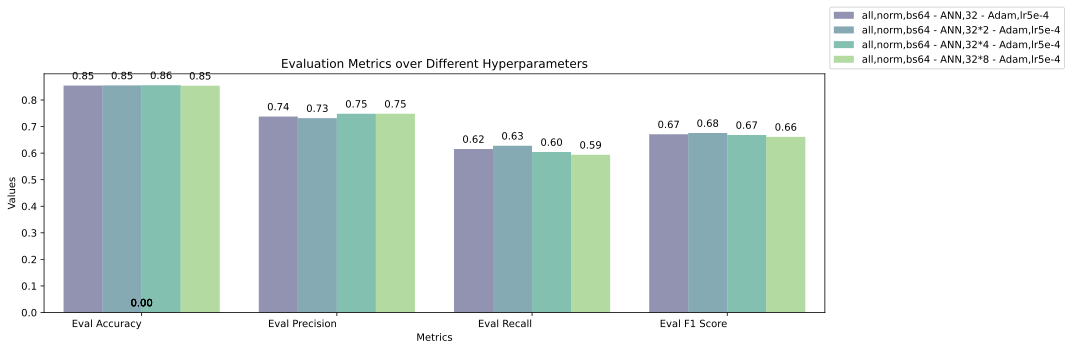

In [12]:
run_experiment(configs)

In [13]:
# To compare ANN width.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,4*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,8*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,16*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,32*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,64*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,4*4', optimizer='Adam,lr5e-4')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.7637236084452975, precision: 1.0, recall: '
 '0.019123505976095617, f1 score: 0.03752931978107897, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1231   24]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.7719769673704414, precision: 0.971830985915493, '
 'recall: 0.0549800796812749, f1 score: 0.10407239819004525, confusion '
 'matrix:\n'
 '[[3

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


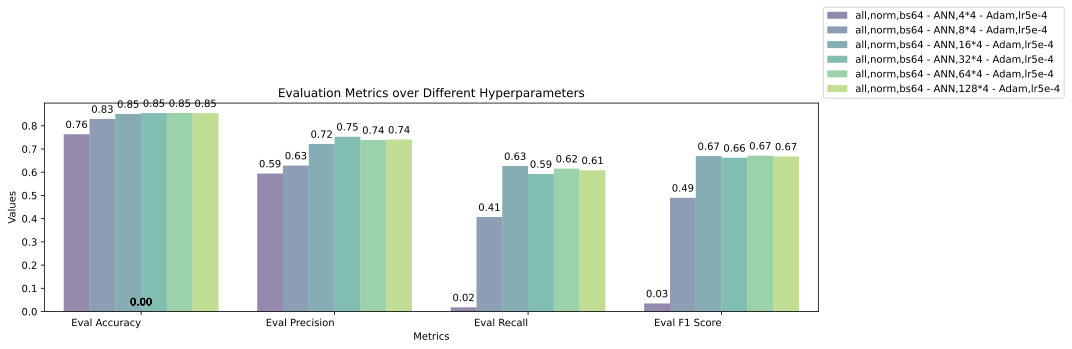

In [14]:
run_experiment(configs)

In [15]:
# To compare model shapes.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,64*5', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,4,16,32,64,128', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,128,64,32,16,4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,4,32,128,32,4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,128,32,4,32,128', optimizer='Adam,lr5e-4'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,64*5', optimizer='Adam,lr5e-4')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.853358925143954, precision: 0.7186108637577916, '
 'recall: 0.6430278884462152, f1 score: 0.6787216148023549, confusion matrix:\n'
 '[[3639  316]\n'
 ' [ 448  807]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.8541266794625719, precision: 0.7548918640576725, '
 'recall: 0.5840637450199203, f1 score: 0.6585804132973945, confusion matrix:\n'
 '[[3717  238]\n'
 ' [ 522  733]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.8573896353166987, precision: 0.7456813819577736, '
 'recall: 0.6191235059760957, f1 

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


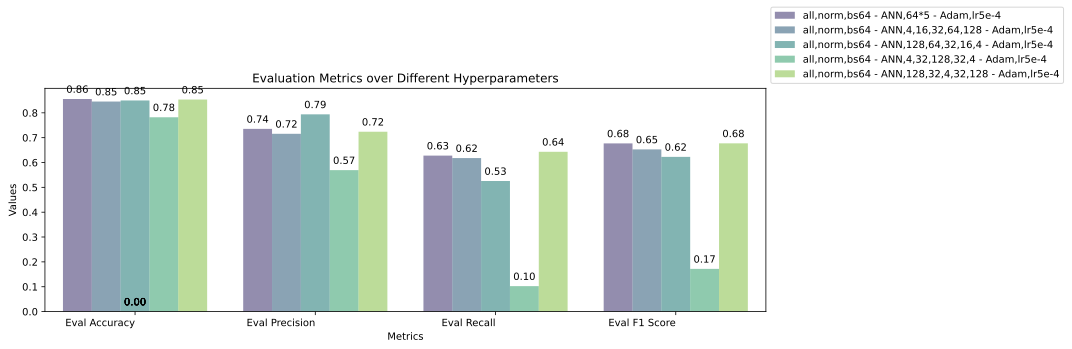

In [16]:
run_experiment(configs)

In [17]:
# To compare different activation functions.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:nan', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:sigmoid', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:tanh', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='Adam,lr5e-4'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:leaky relu', optimizer='Adam,lr5e-4'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:nan', optimizer='Adam,lr5e-4')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.8520153550863724, precision: 0.7400793650793651, '
 'recall: 0.5944223107569722, f1 score: 0.6593018117543085, confusion matrix:\n'
 '[[3693  262]\n'
 ' [ 509  746]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.8510556621880998, precision: 0.7270142180094786, '
 'recall: 0.6111553784860557, f1 score: 0.664069264069264, confusion matrix:\n'
 '[[3667  288]\n'
 ' [ 488  767]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.8568138195777352, precision: 0.7468477206595538, '
 'recall: 0.613545816733

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


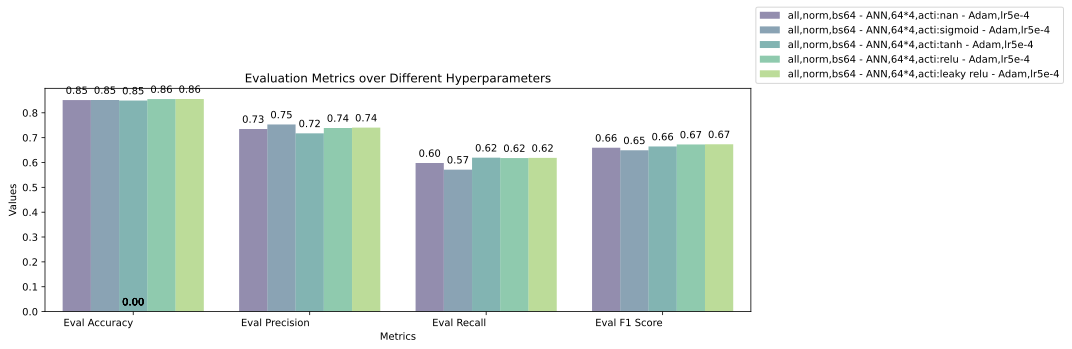

In [18]:
run_experiment(configs)

In [31]:
# To compare different learning rates.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='SGD,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='SGD,lr1e-2'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='SGD,lr1e-1'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='Adam,lr1e-2'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='Adam,lr1e-1'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu', optimizer='SGD,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'4/5 fold Train size:20839, Val size:5209

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


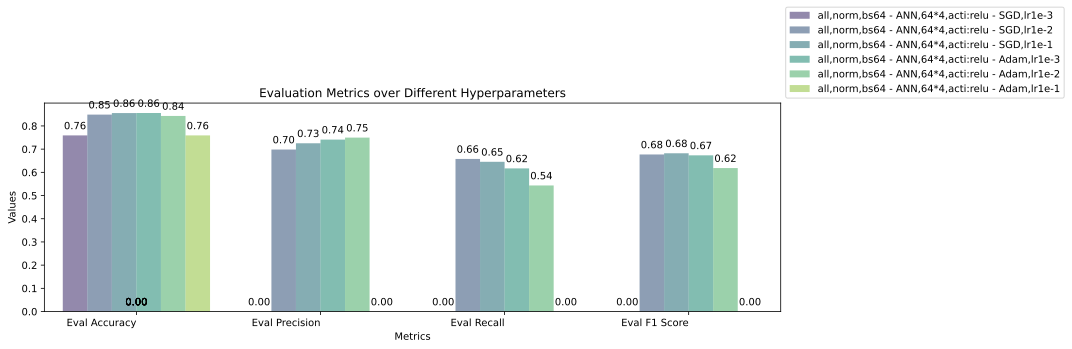

In [32]:
run_experiment(configs)

In [21]:
# To compare different dropout rates.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.1', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.3', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.7', optimizer='Adam,lr1e-3'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'


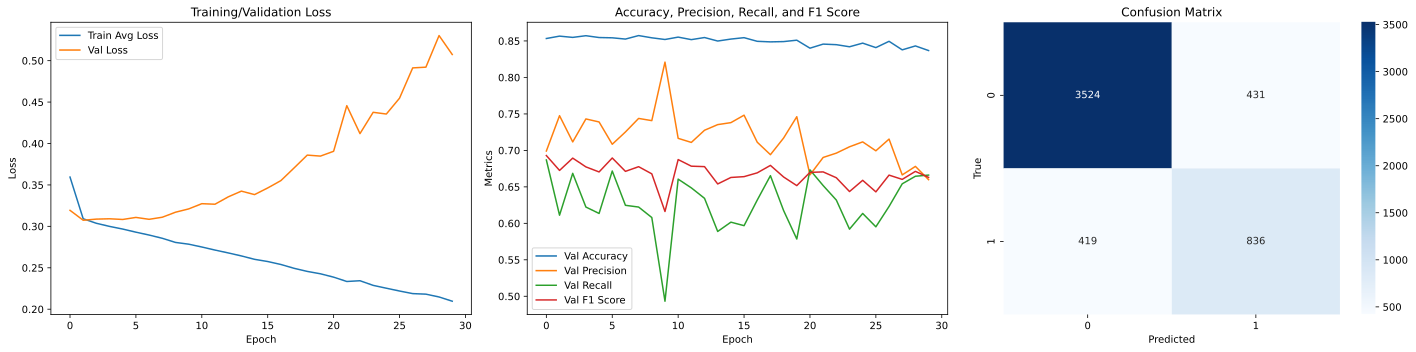

('1/5 fold Eval accuracy: 0.836852207293666, precision: 0.65982636148382, '
 'recall: 0.6661354581673307, f1 score: 0.6629659000793021, confusion matrix:\n'
 '[[3524  431]\n'
 ' [ 419  836]]')
'2/5 fold Train size:20838, Val size:5210'


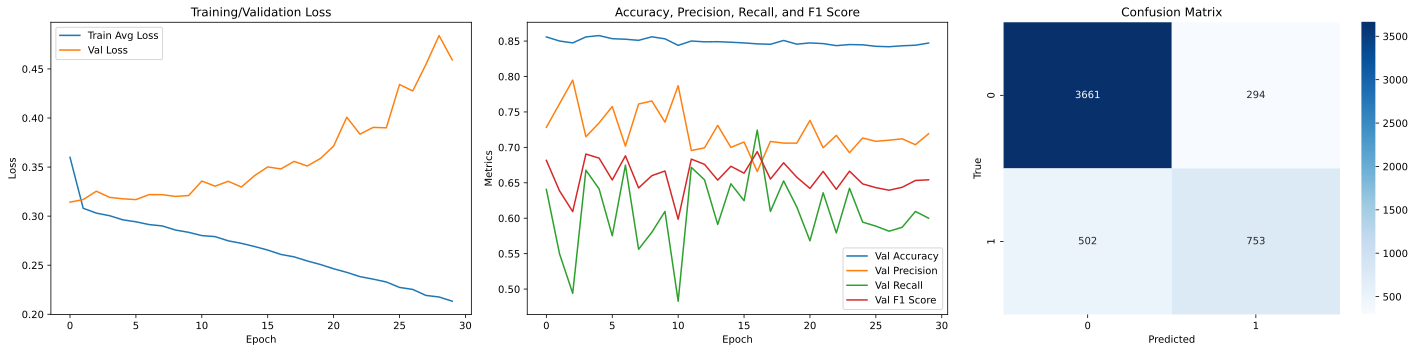

('2/5 fold Eval accuracy: 0.8472168905950096, precision: 0.7191977077363897, '
 'recall: 0.6, f1 score: 0.6542137271937446, confusion matrix:\n'
 '[[3661  294]\n'
 ' [ 502  753]]')
'3/5 fold Train size:20838, Val size:5210'


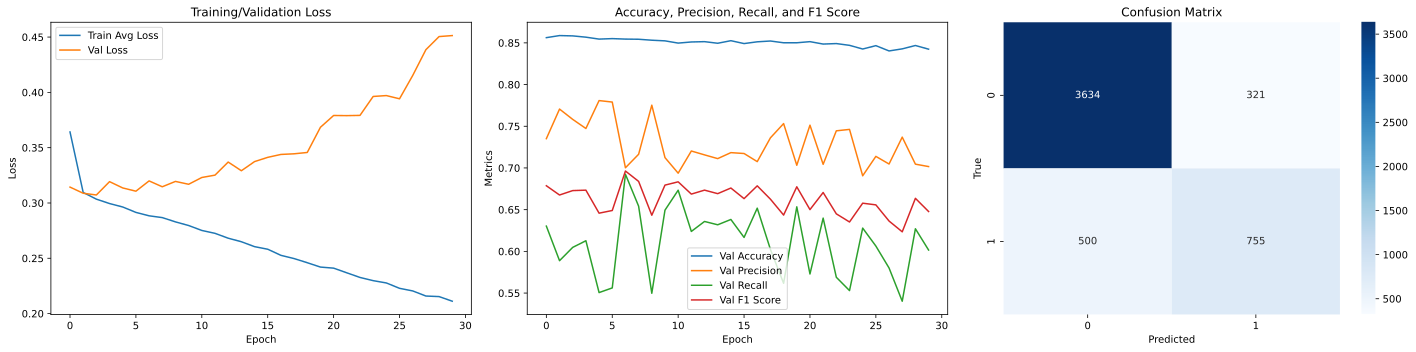

('3/5 fold Eval accuracy: 0.8424184261036468, precision: 0.7016728624535316, '
 'recall: 0.601593625498008, f1 score: 0.6477906477906478, confusion matrix:\n'
 '[[3634  321]\n'
 ' [ 500  755]]')
'4/5 fold Train size:20839, Val size:5209'


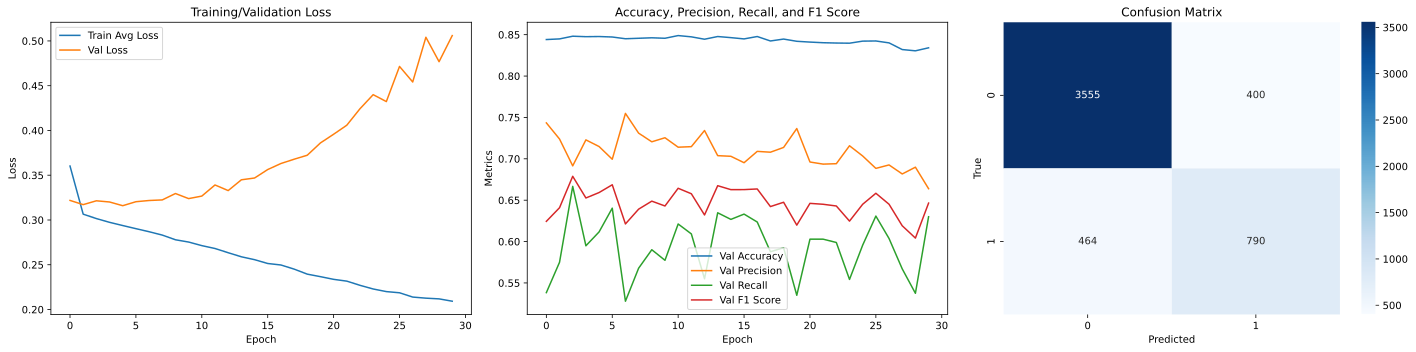

('4/5 fold Eval accuracy: 0.8341332309464389, precision: 0.6638655462184874, '
 'recall: 0.6299840510366826, f1 score: 0.646481178396072, confusion matrix:\n'
 '[[3555  400]\n'
 ' [ 464  790]]')
'5/5 fold Train size:20839, Val size:5209'


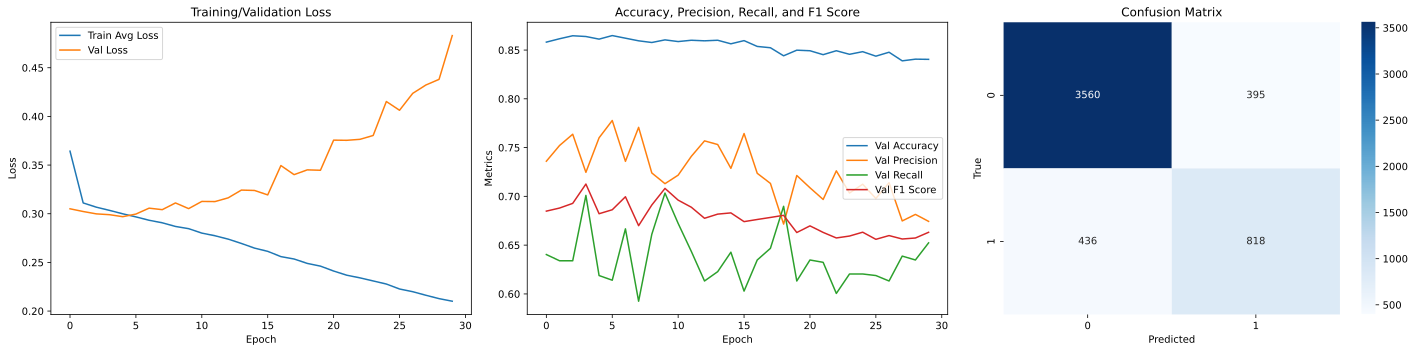

('5/5 fold Eval accuracy: 0.8404684200422345, precision: 0.674361088211047, '
 'recall: 0.6523125996810207, f1 score: 0.6631536278881233, confusion matrix:\n'
 '[[3560  395]\n'
 ' [ 436  818]]')
'5 fold Average Eval accuracy: 0.8402178349961992'
'5 fold Average Eval precision: 0.6837847132206551'
'5 fold Average Eval recall: 0.6300051468766084'
'5 fold Average Eval f1 score: 0.654921016269578'
'5 fold Average Eval confusion matrix:\n[[3586.8  368.2]\n [ 464.2  790.4]]'
Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.1', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'


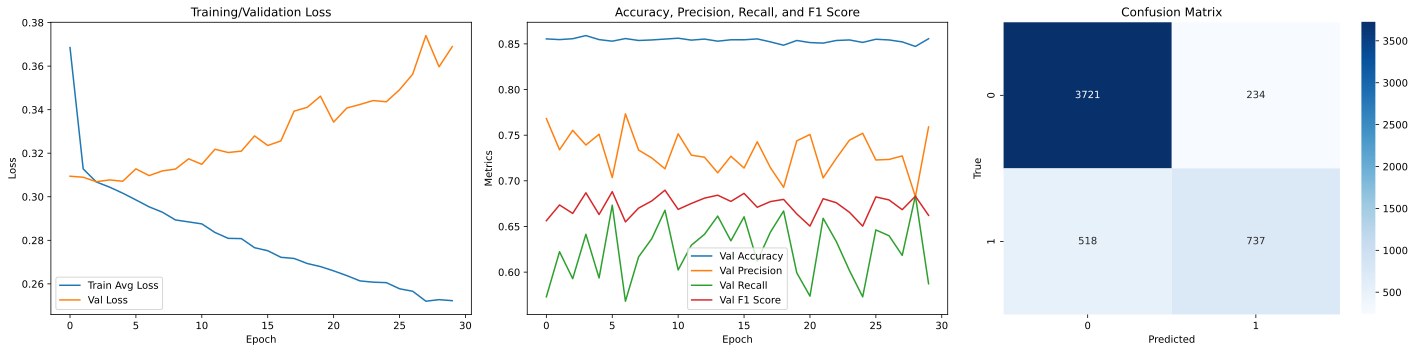

('1/5 fold Eval accuracy: 0.8556621880998081, precision: 0.7590113285272915, '
 'recall: 0.5872509960159362, f1 score: 0.6621743036837376, confusion matrix:\n'
 '[[3721  234]\n'
 ' [ 518  737]]')
'2/5 fold Train size:20838, Val size:5210'


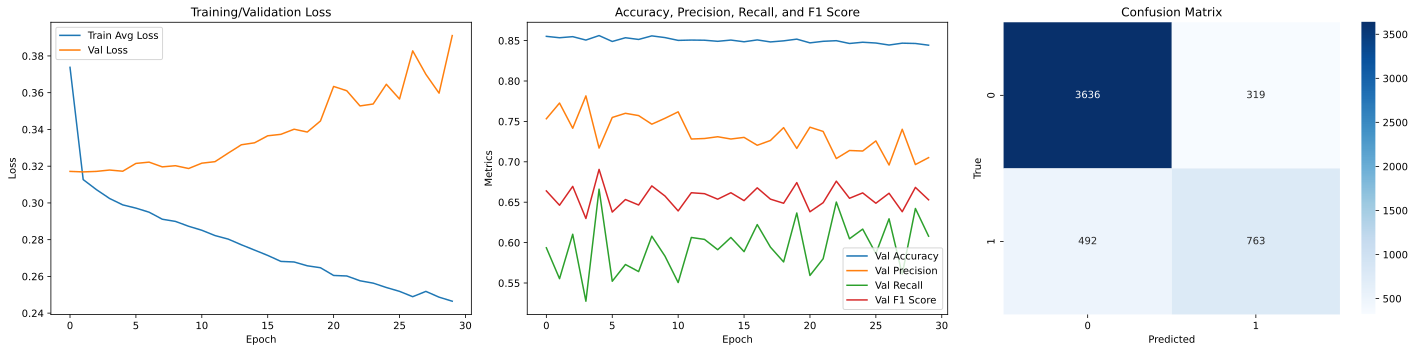

('2/5 fold Eval accuracy: 0.844337811900192, precision: 0.7051756007393716, '
 'recall: 0.6079681274900398, f1 score: 0.6529738981600343, confusion matrix:\n'
 '[[3636  319]\n'
 ' [ 492  763]]')
'3/5 fold Train size:20838, Val size:5210'


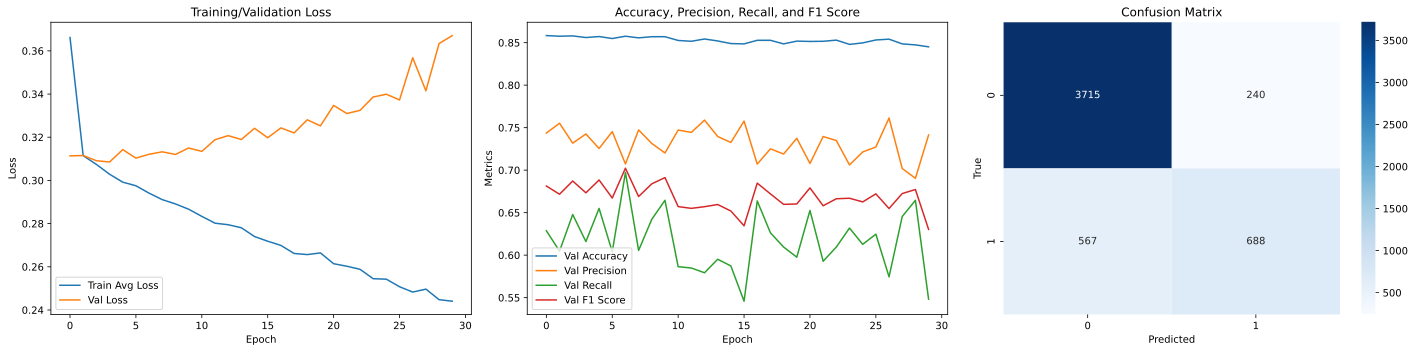

('3/5 fold Eval accuracy: 0.84510556621881, precision: 0.7413793103448276, '
 'recall: 0.5482071713147411, f1 score: 0.630325240494732, confusion matrix:\n'
 '[[3715  240]\n'
 ' [ 567  688]]')
'4/5 fold Train size:20839, Val size:5209'


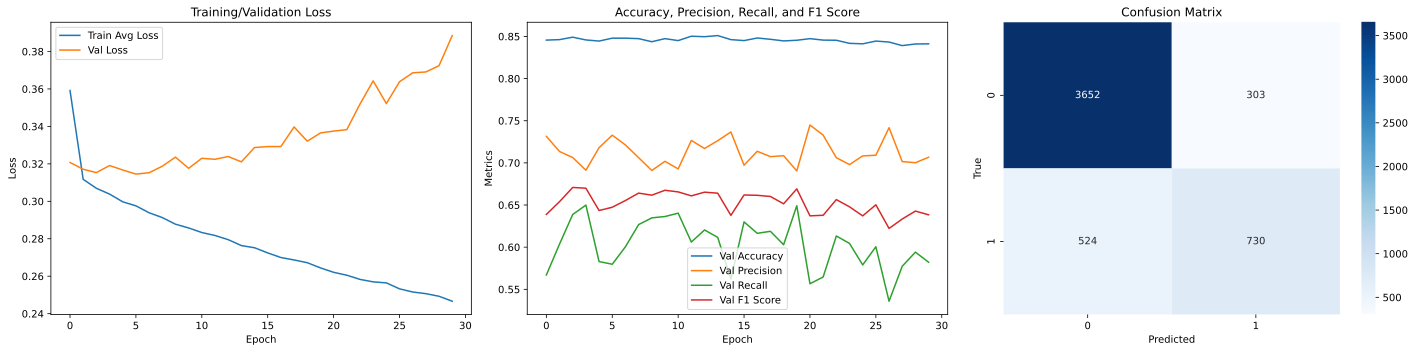

('4/5 fold Eval accuracy: 0.8412363217508159, precision: 0.7066795740561471, '
 'recall: 0.5821371610845295, f1 score: 0.6383909051158724, confusion matrix:\n'
 '[[3652  303]\n'
 ' [ 524  730]]')
'5/5 fold Train size:20839, Val size:5209'


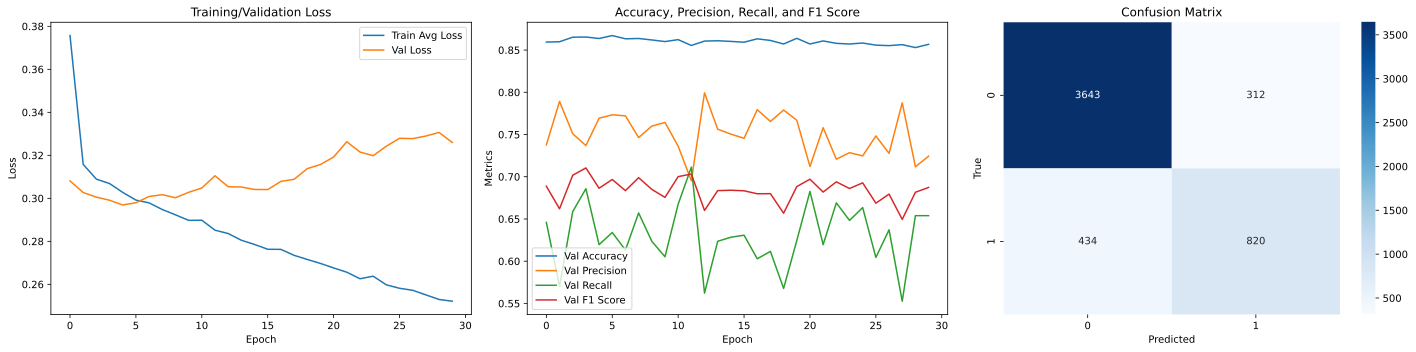

('5/5 fold Eval accuracy: 0.8567863313495873, precision: 0.7243816254416962, '
 'recall: 0.6539074960127592, f1 score: 0.6873428331936295, confusion matrix:\n'
 '[[3643  312]\n'
 ' [ 434  820]]')
'5 fold Average Eval accuracy: 0.8486256438638426'
'5 fold Average Eval precision: 0.7273254878218668'
'5 fold Average Eval recall: 0.5958941903836011'
'5 fold Average Eval f1 score: 0.6542414361296012'
'5 fold Average Eval confusion matrix:\n[[3673.4  281.6]\n [ 507.   747.6]]'
Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.3', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'


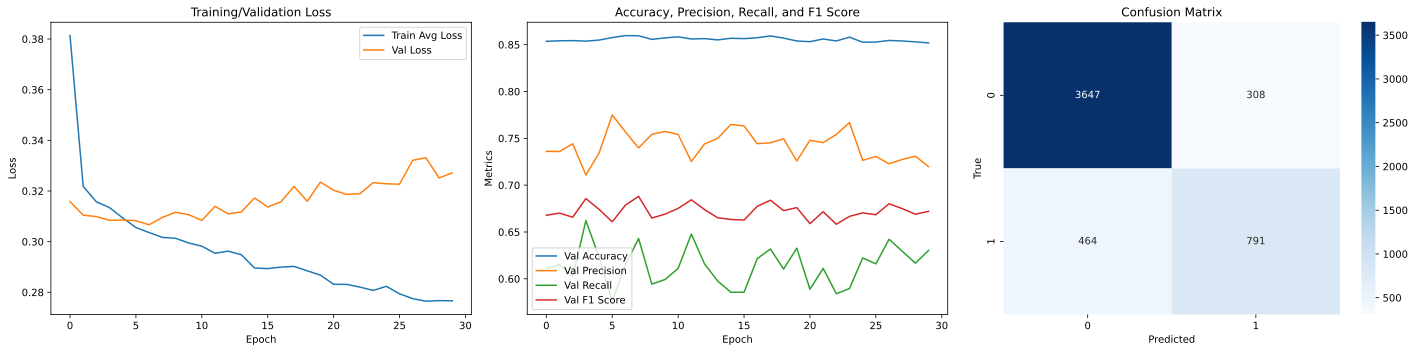

('1/5 fold Eval accuracy: 0.8518234165067179, precision: 0.7197452229299363, '
 'recall: 0.6302788844621514, f1 score: 0.6720475785896347, confusion matrix:\n'
 '[[3647  308]\n'
 ' [ 464  791]]')
'2/5 fold Train size:20838, Val size:5210'


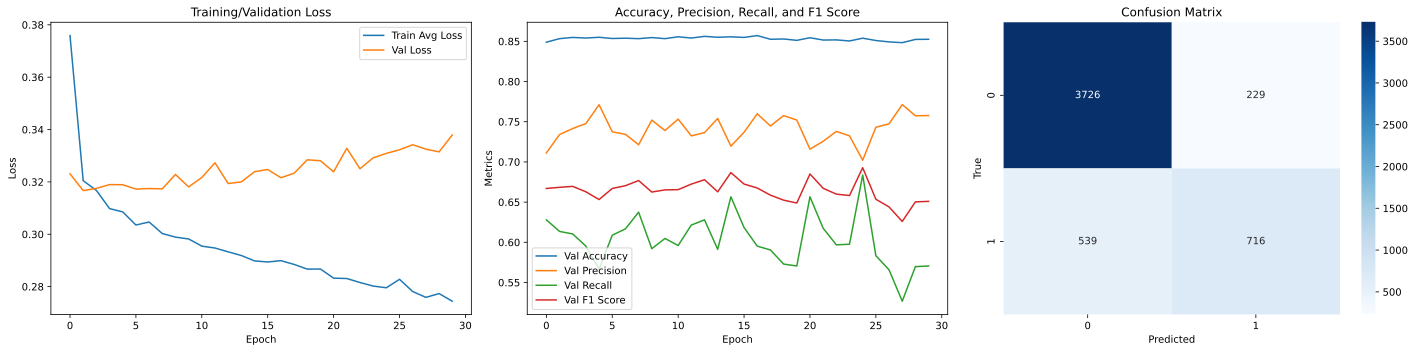

('2/5 fold Eval accuracy: 0.8525911708253359, precision: 0.7576719576719577, '
 'recall: 0.5705179282868525, f1 score: 0.6509090909090909, confusion matrix:\n'
 '[[3726  229]\n'
 ' [ 539  716]]')
'3/5 fold Train size:20838, Val size:5210'


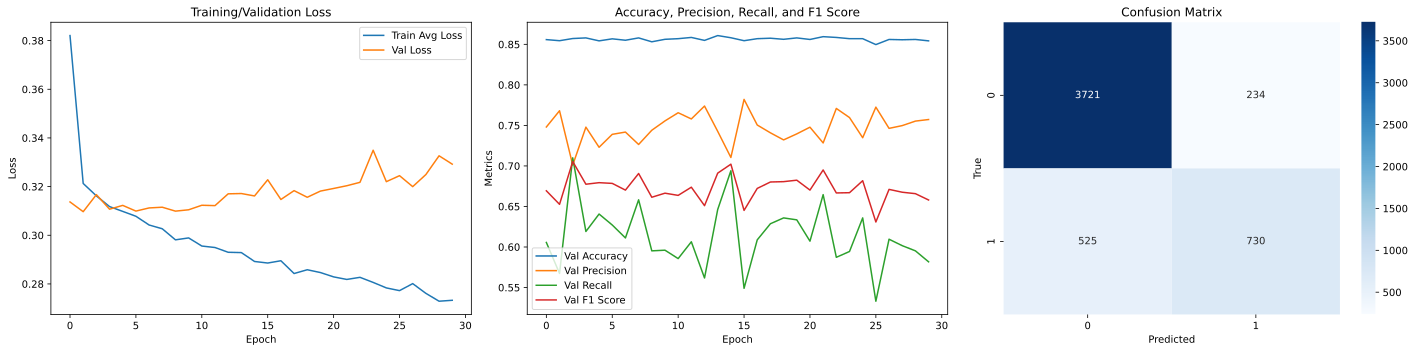

('3/5 fold Eval accuracy: 0.8543186180422265, precision: 0.7572614107883817, '
 'recall: 0.5816733067729084, f1 score: 0.6579540333483551, confusion matrix:\n'
 '[[3721  234]\n'
 ' [ 525  730]]')
'4/5 fold Train size:20839, Val size:5209'


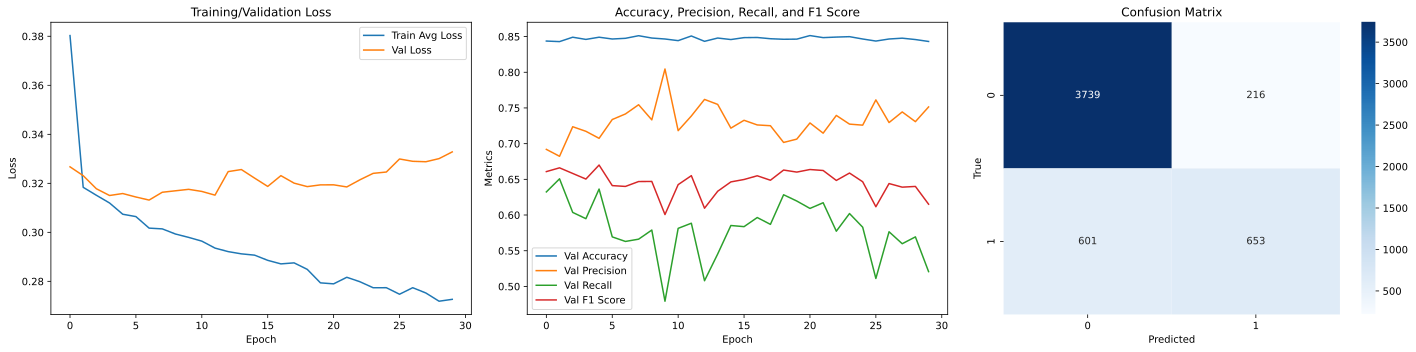

('4/5 fold Eval accuracy: 0.8431560760222692, precision: 0.7514384349827388, '
 'recall: 0.5207336523125997, f1 score: 0.6151672162034856, confusion matrix:\n'
 '[[3739  216]\n'
 ' [ 601  653]]')
'5/5 fold Train size:20839, Val size:5209'


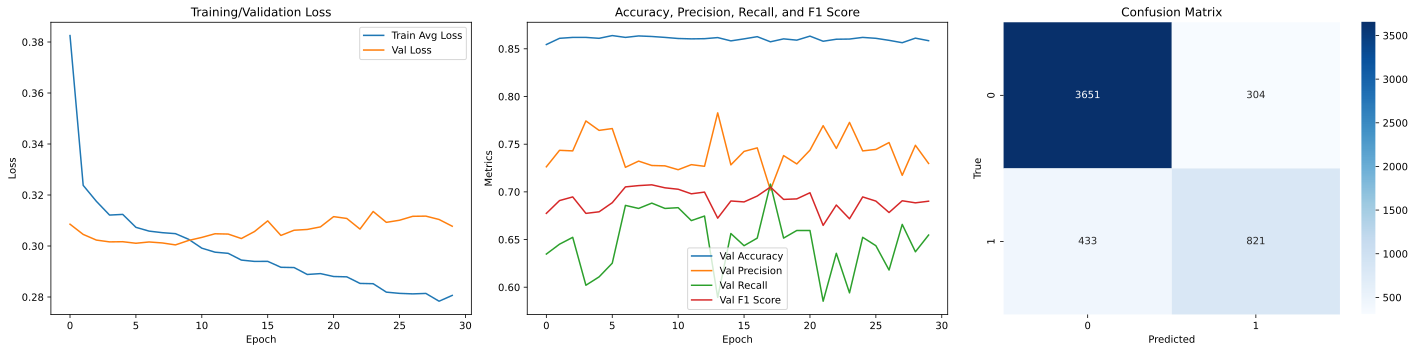

('5/5 fold Eval accuracy: 0.8585141101938952, precision: 0.7297777777777777, '
 'recall: 0.6547049441786283, f1 score: 0.6902059688944935, confusion matrix:\n'
 '[[3651  304]\n'
 ' [ 433  821]]')
'5 fold Average Eval accuracy: 0.852080678318089'
'5 fold Average Eval precision: 0.7431789608301584'
'5 fold Average Eval recall: 0.5915817432026281'
'5 fold Average Eval f1 score: 0.6572567775890119'
'5 fold Average Eval confusion matrix:\n[[3696.8  258.2]\n [ 512.4  742.2]]'
Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'


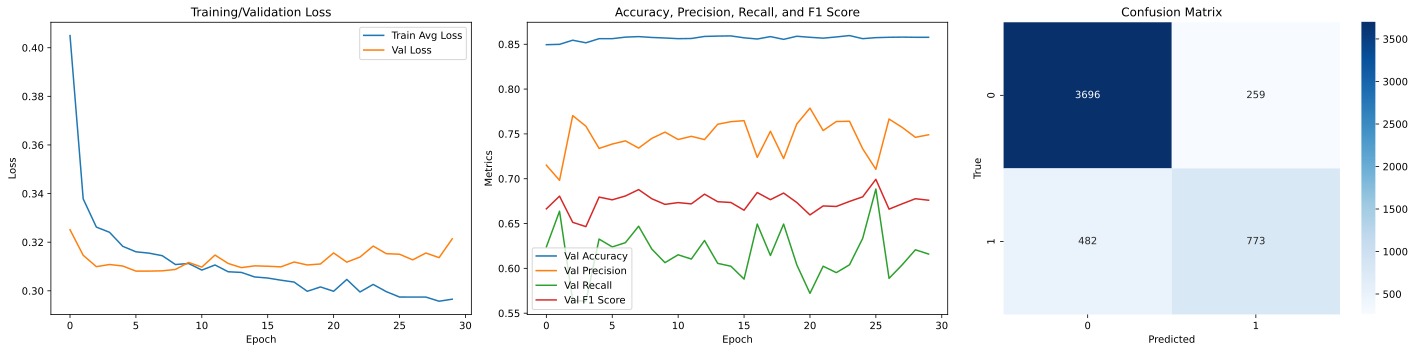

('1/5 fold Eval accuracy: 0.8577735124760076, precision: 0.749031007751938, '
 'recall: 0.6159362549800796, f1 score: 0.6759947529514648, confusion matrix:\n'
 '[[3696  259]\n'
 ' [ 482  773]]')
'2/5 fold Train size:20838, Val size:5210'


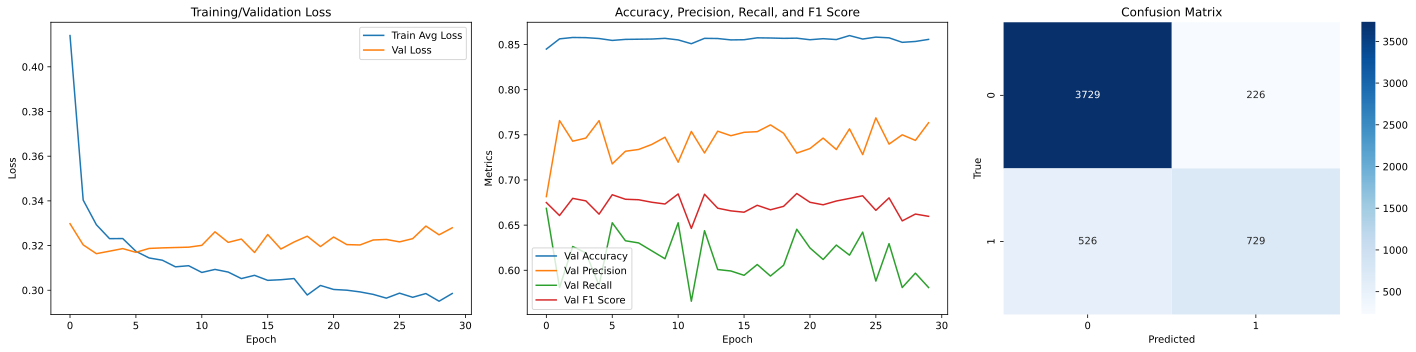

('2/5 fold Eval accuracy: 0.8556621880998081, precision: 0.7633507853403141, '
 'recall: 0.5808764940239044, f1 score: 0.6597285067873303, confusion matrix:\n'
 '[[3729  226]\n'
 ' [ 526  729]]')
'3/5 fold Train size:20838, Val size:5210'


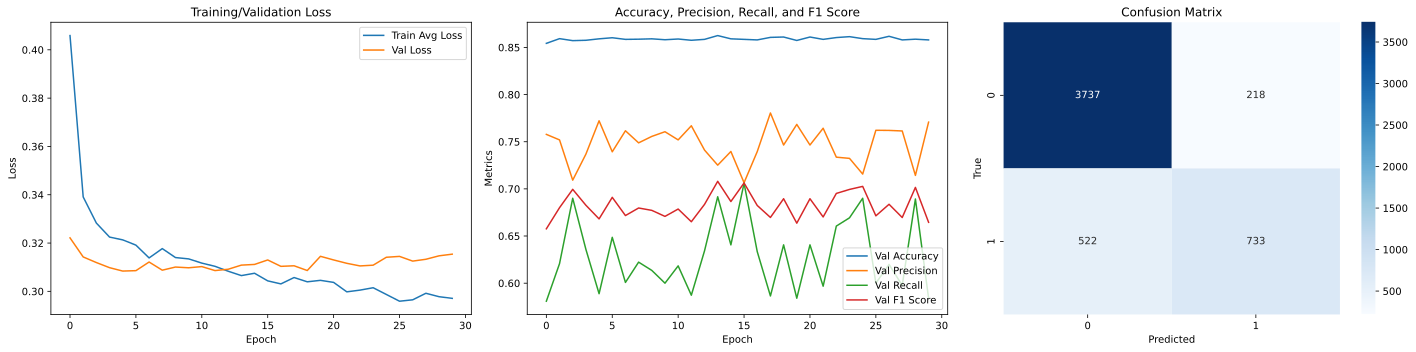

('3/5 fold Eval accuracy: 0.8579654510556622, precision: 0.7707676130389064, '
 'recall: 0.5840637450199203, f1 score: 0.6645512239347234, confusion matrix:\n'
 '[[3737  218]\n'
 ' [ 522  733]]')
'4/5 fold Train size:20839, Val size:5209'


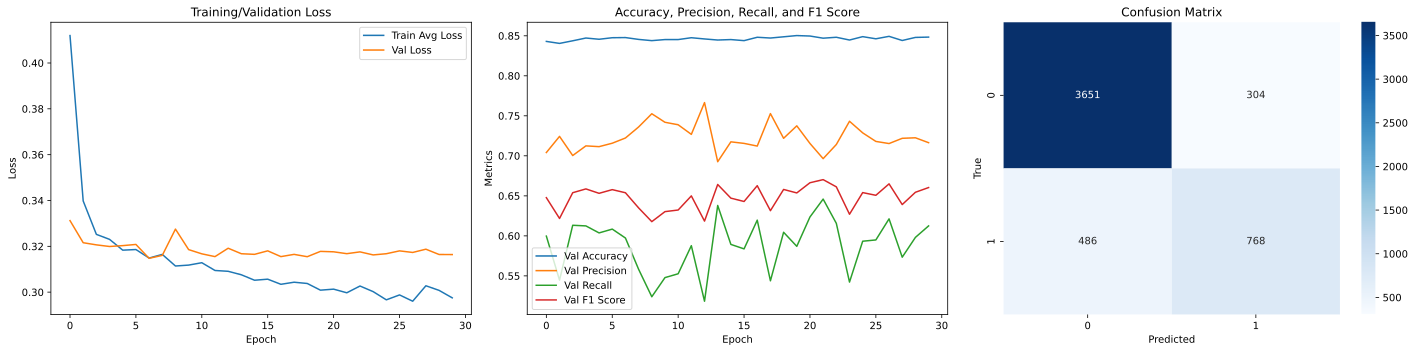

('4/5 fold Eval accuracy: 0.848339412555193, precision: 0.7164179104477612, '
 'recall: 0.6124401913875598, f1 score: 0.6603611349957008, confusion matrix:\n'
 '[[3651  304]\n'
 ' [ 486  768]]')
'5/5 fold Train size:20839, Val size:5209'


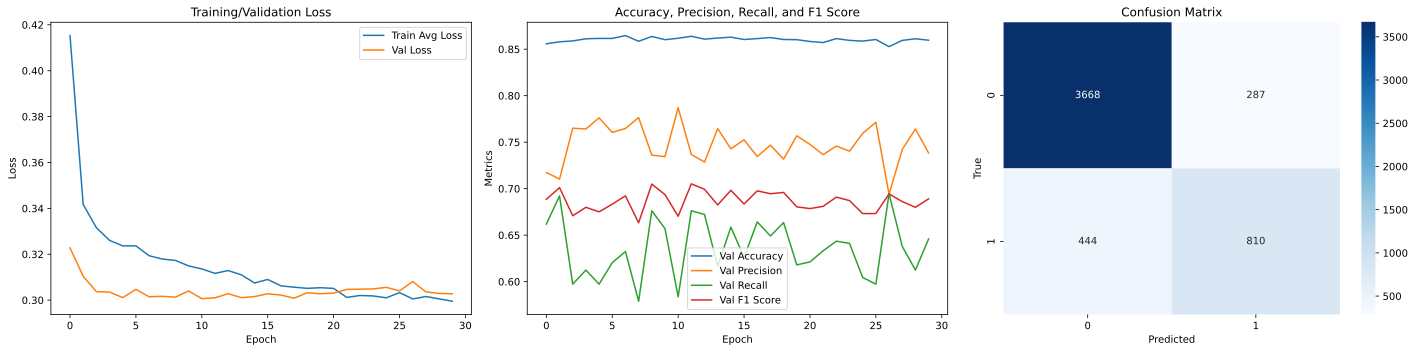

('5/5 fold Eval accuracy: 0.8596659627567671, precision: 0.7383773928896992, '
 'recall: 0.645933014354067, f1 score: 0.6890684814972352, confusion matrix:\n'
 '[[3668  287]\n'
 ' [ 444  810]]')
'5 fold Average Eval accuracy: 0.8558813053886876'
'5 fold Average Eval precision: 0.7475889418937237'
'5 fold Average Eval recall: 0.6078499399531062'
'5 fold Average Eval f1 score: 0.6699408200332909'
'5 fold Average Eval confusion matrix:\n[[3696.2  258.8]\n [ 492.   762.6]]'
Config: Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.7', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'


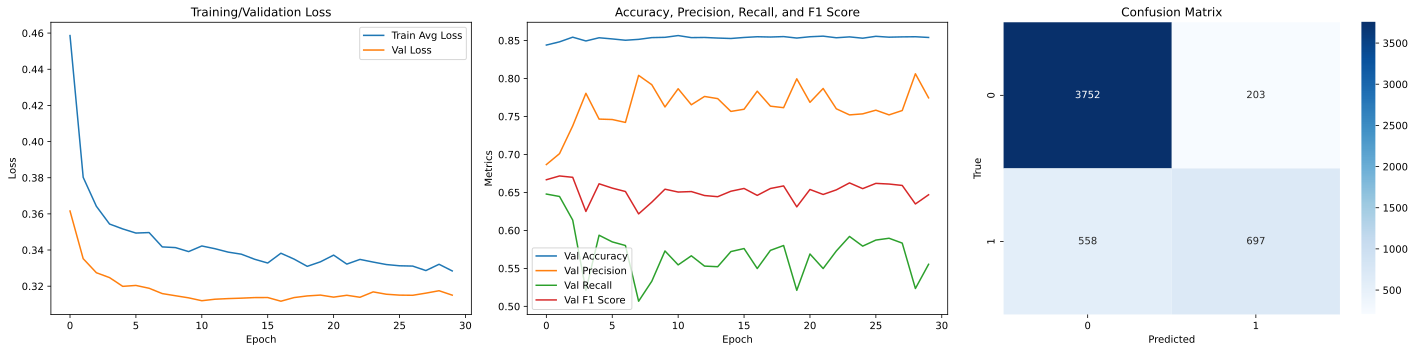

('1/5 fold Eval accuracy: 0.8539347408829174, precision: 0.7744444444444445, '
 'recall: 0.5553784860557769, f1 score: 0.6468677494199536, confusion matrix:\n'
 '[[3752  203]\n'
 ' [ 558  697]]')
'2/5 fold Train size:20838, Val size:5210'


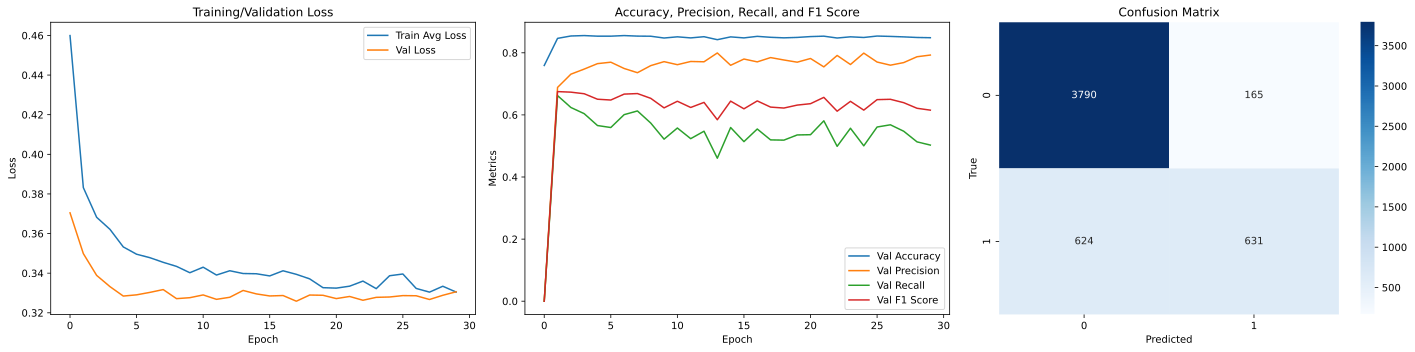

('2/5 fold Eval accuracy: 0.8485604606525912, precision: 0.792713567839196, '
 'recall: 0.502788844621514, f1 score: 0.6153096050706972, confusion matrix:\n'
 '[[3790  165]\n'
 ' [ 624  631]]')
'3/5 fold Train size:20838, Val size:5210'


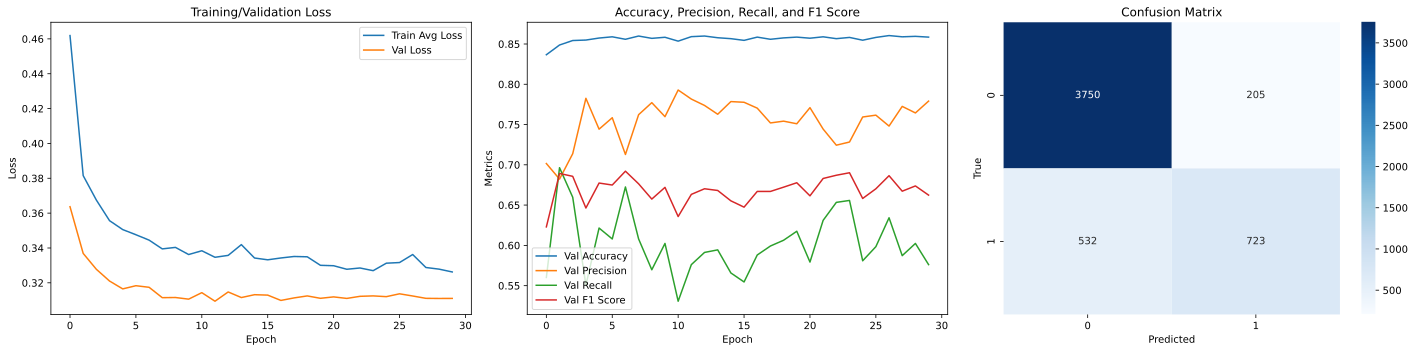

('3/5 fold Eval accuracy: 0.8585412667946257, precision: 0.7790948275862069, '
 'recall: 0.5760956175298805, f1 score: 0.6623912047640861, confusion matrix:\n'
 '[[3750  205]\n'
 ' [ 532  723]]')
'4/5 fold Train size:20839, Val size:5209'


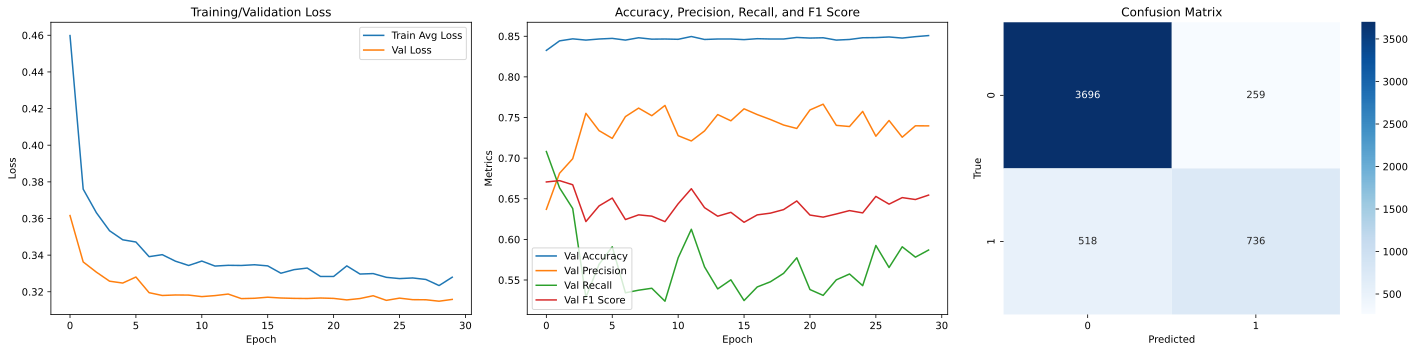

('4/5 fold Eval accuracy: 0.8508350931080821, precision: 0.7396984924623116, '
 'recall: 0.5869218500797448, f1 score: 0.6545131169408626, confusion matrix:\n'
 '[[3696  259]\n'
 ' [ 518  736]]')
'5/5 fold Train size:20839, Val size:5209'


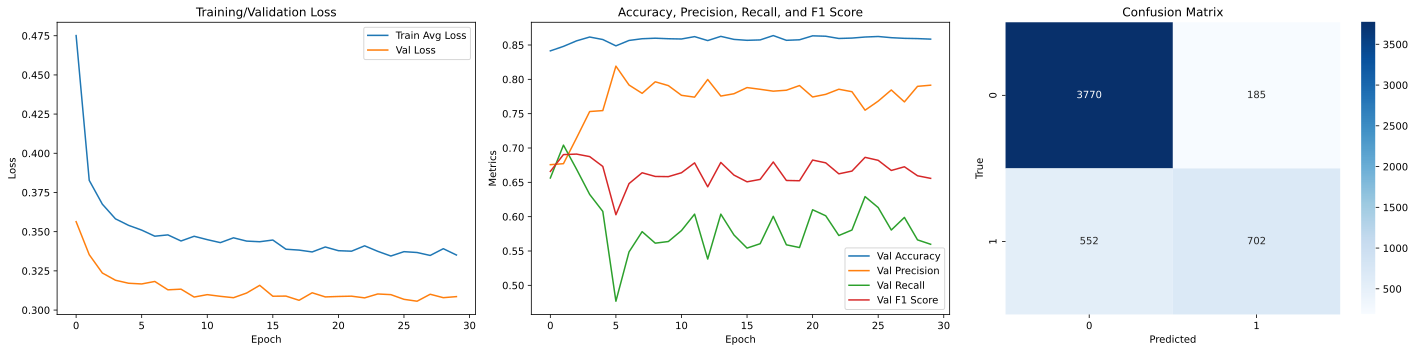

('5/5 fold Eval accuracy: 0.8585141101938952, precision: 0.7914317925591883, '
 'recall: 0.5598086124401914, f1 score: 0.6557683325548809, confusion matrix:\n'
 '[[3770  185]\n'
 ' [ 552  702]]')
'5 fold Average Eval accuracy: 0.8540771343264223'
'5 fold Average Eval precision: 0.7754766249782694'
'5 fold Average Eval recall: 0.5561986821454216'
'5 fold Average Eval f1 score: 0.6469700017500961'
'5 fold Average Eval confusion matrix:\n[[3751.6  203.4]\n [ 556.8  697.8]]'


/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


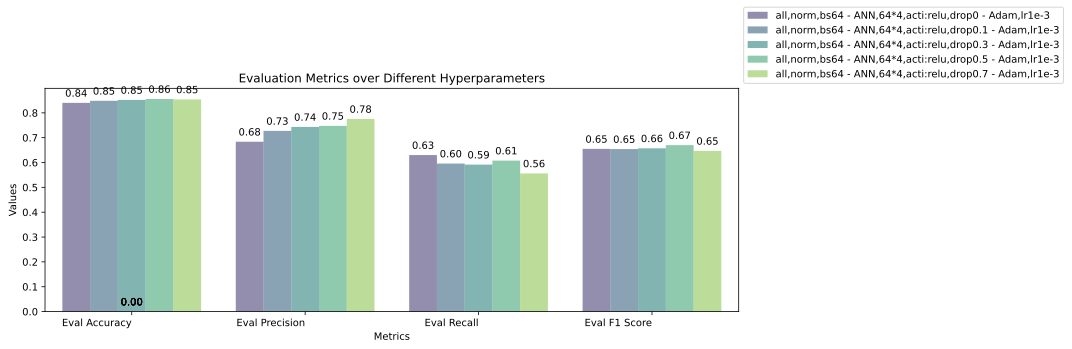

In [22]:
run_experiment(configs, plot=True)

In [23]:
# To compare different dataset preprocessing logics.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,32*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='drop,123a3b3c,norm,bs64', model='ANN,32*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='drop,123a3b3c,norm,bs64', model='ANN,64*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,32*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.8568138195777352, precision: 0.7763300760043431, '
 'recall: 0.5697211155378487, f1 score: 0.6571691176470589, confusion matrix:\n'
 '[[3749  206]\n'
 ' [ 540  715]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.8523992322456814, precision: 0.7401185770750988, '
 'recall: 0.5968127490039841, f1 score: 0.6607851786501985, confusion matrix:\n'
 '[[3692  263]\n'
 ' [ 506  749]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.8577735124760076, precision: 0.7370848708487084, '
 'recall: 0.63

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


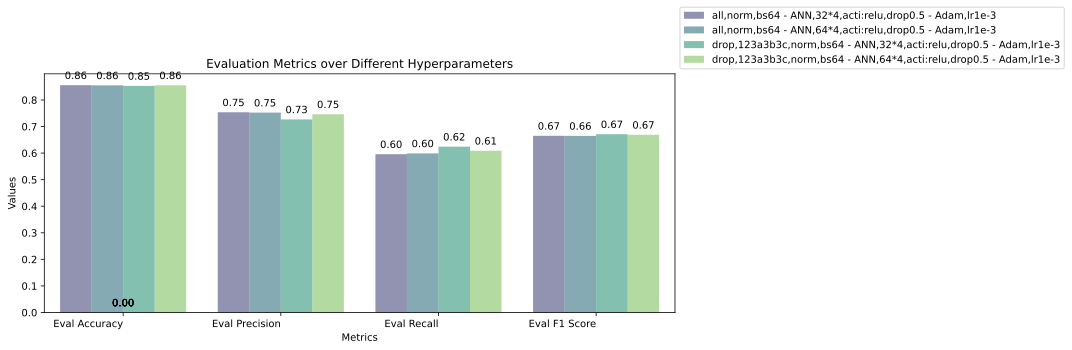

In [24]:
run_experiment(configs)

In [29]:
# To compare with/without normalization.
configs = [
    Config(dataset='all,no-norm,bs64', model='ANN,32*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,32*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='all,no-norm,bs64', model='ANN,64*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
    Config(dataset='all,norm,bs64', model='ANN,64*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3'),
]

Config: Config(dataset='all,no-norm,bs64', model='ANN,32*4,acti:relu,drop0.5', optimizer='Adam,lr1e-3')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.7591170825335892, precision: 0.0, recall: 0.0, f1 '
 'score: 0.0, confusion matrix:\n'
 '[[3955    0]\n'
 ' [1255    0]]')
'4/5 fold Train size:20839, Val size:5209'
('4/5 fold Eval accuracy: 0.759262814359762, p

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


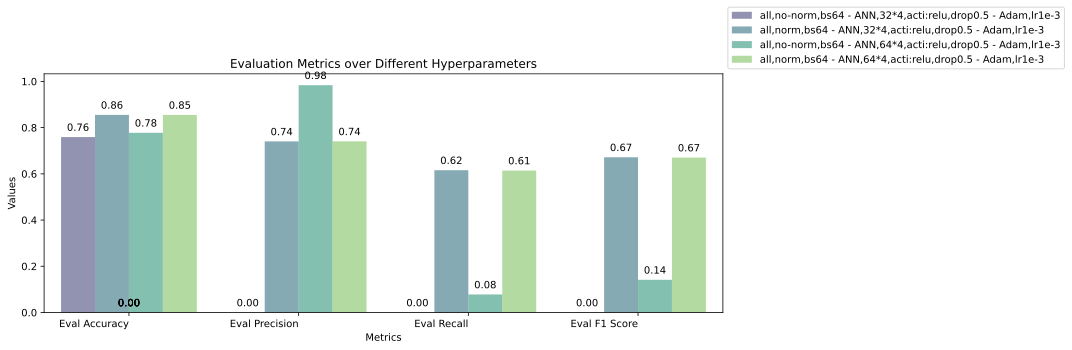

In [30]:
run_experiment(configs)

In [33]:
# To compare Data Preprocessing.
configs = [
    Config(dataset='all,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='drop,123a3b3c,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='drop,1,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='drop,2,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='drop,3a,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='drop,3b,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='drop,3c,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
    Config(dataset='all,ord,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4'),
]

Config: Config(dataset='all,norm,bs64', model='ANN,128*4', optimizer='Adam,lr5e-4')

Before one hot, feature train shape: (26048, 14)

Before one hot, feature test shape: (6513, 14)

Categorical features after onehot encoding:

Shape: (26048, 102)

Continues features after normalization:

Shape: (26048, 6)

feature_onehot_train_tensor shape: torch.Size([26048, 102])
'1/5 fold Train size:20838, Val size:5210'
('1/5 fold Eval accuracy: 0.8598848368522073, precision: 0.744641192917055, '
 'recall: 0.6366533864541832, f1 score: 0.686426116838488, confusion matrix:\n'
 '[[3681  274]\n'
 ' [ 456  799]]')
'2/5 fold Train size:20838, Val size:5210'
('2/5 fold Eval accuracy: 0.8554702495201536, precision: 0.7294332723948812, '
 'recall: 0.6358565737051792, f1 score: 0.6794380587484036, confusion matrix:\n'
 '[[3659  296]\n'
 ' [ 457  798]]')
'3/5 fold Train size:20838, Val size:5210'
('3/5 fold Eval accuracy: 0.8570057581573897, precision: 0.726063829787234, '
 'recall: 0.6525896414342629, f1 s

/tmp/ipykernel_106181/3574702523.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


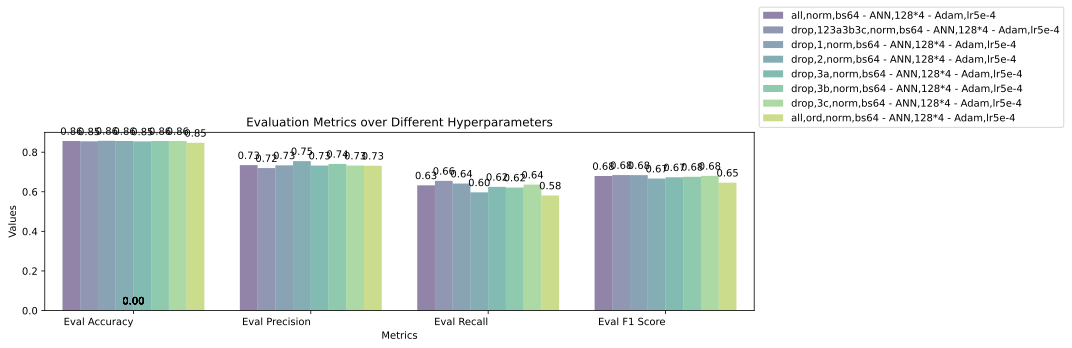

In [34]:
run_experiment(configs)